
<a id='aiyagari'></a>

# Solving Heterogenous Agents Model
<!-- Include MathJax in the HTML head -->
<script type="text/javascript" async
    src="https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.7/MathJax.js?config=TeX-MML-AM_CHTML">
</script>

Overview and description of economy taken from Chapter 54, Quantitative Economics with Julia [[link](https://julia.quantecon.org/multi_agent_models/aiyagari.html)]

## Contents

- The Aiyagari Model  
  - Overview  
  - The Economy
    - Households
    - Firms
  - Equilibrium
  - Sketch Code
- Solving the Aiyagari with fixed prices:
  - Value Function Iteration
  - Policy Function Iteration
  - Endogenous Grid Method 
- Stationary Distribution
  - Simulations 
  - Young's Method
- Equilibrium 
- Using QuantEcon Routines

## The Aiyagari Model 


### Overview



In this lecture we describe the structure of a class of models that build on work by Truman Bewley [[Bew77](https://julia.quantecon.org/../zreferences.html#id92)].

The model features

- Heterogeneous agents.  
- A single exogenous vehicle for borrowing and lending.  
- Limits on amounts individual agents may borrow.  


The Aiyagari model has been used to investigate many topics, including

- precautionary savings and the effect of liquidity constraints [[Aiy94](https://julia.quantecon.org/../zreferences.html#id57)]  
- risk sharing and asset pricing [[HL96](https://julia.quantecon.org/../zreferences.html#id48)]  
- the shape of the wealth distribution [[BBZ15](https://julia.quantecon.org/../zreferences.html#id49)]  
- etc., etc., etc.  

References:

- The primary reference for this lecture is [[Aiy94](https://julia.quantecon.org/../zreferences.html#id57)].
- A textbook treatment is available in chapter 18 of [[LS18](https://julia.quantecon.org/../zreferences.html#id101)].
- A continuous time version of the model by SeHyoun Ahn and Benjamin Moll can be found [here](http://nbviewer.jupyter.org/github/QuantEcon/QuantEcon.notebooks/blob/master/aiyagari_continuous_time.ipynb).

### The Economy

#### Households

Infinitely lived households / consumers face idiosyncratic income shocks.

A unit interval of  *ex ante* identical households face a common borrowing constraint.

The savings problem faced by a typical  household is

$$
\max \mathbb E \sum_{t=0}^{\infty} \beta^t u(c_t)
$$

subject to

$$
a_{t+1} + c_t \leq w z_t + (1 + r) a_t
\quad
c_t \geq 0,
\quad \text{and} \quad
a_t \geq -B
$$

where

- $ c_t $ is current consumption  
- $ a_t $ is assets  
- $ z_t $ is an exogenous component of labor income capturing stochastic unemployment risk, etc.  
- $ w $ is a wage rate  
- $ r $ is a net interest rate  
- $ B $ is the maximum amount that the agent is allowed to borrow  


The exogenous process $ \{z_t\} $ follows a finite state Markov chain with given stochastic matrix $ P $.

The wage and interest rate are fixed over time.

In this simple version of the model, households supply labor  inelastically because they do not value leisure.

#### Firms

Firms produce output by hiring capital and labor.

Firms act competitively and face constant returns to scale.

Since returns to scale are constant the number of firms does not matter.

Hence we can consider a single (but nonetheless competitive) representative firm.

The firm’s output is

$$
Y_t = A K_t^{\alpha} N^{1 - \alpha}
$$

where

- $ A $ and $ \alpha $ are parameters with $ A > 0 $ and $ \alpha \in (0, 1) $  
- $ K_t $ is aggregate capital  
- $ N $ is total labor supply (which is constant in this simple version of the model)  


The firm’s problem is

$$
max_{K, N} \left\{ A K_t^{\alpha} N^{1 - \alpha} - (r + \delta) K - w N \right\}
$$

The parameter $ \delta $ is the depreciation rate.

From the first-order condition with respect to capital, the firm’s inverse demand for capital is


<a id='equation-aiy-rgk'></a>
$$
r = A \alpha  \left( \frac{N}{K} \right)^{1 - \alpha} - \delta \tag{54.1}
$$

Using this expression and the firm’s first-order condition for labor, we can pin down
the equilibrium wage rate as a function of $ r $ as


<a id='equation-aiy-wgr'></a>
$$
w(r) = A  (1 - \alpha)  (A \alpha / (r + \delta))^{\alpha / (1 - \alpha)} \tag{54.2}
$$


### Equilibrium

We construct  a *stationary rational expectations equilibrium* (SREE).

In such an equilibrium

- prices induce behavior that generates aggregate quantities consistent with the prices  
- aggregate quantities and prices are constant over time  


In more detail, an SREE lists a set of prices, savings and production policies such that

- households want to choose the specified savings policies taking the prices as given  
- firms maximize profits taking the same prices as given  
- the resulting aggregate quantities are consistent with the prices; in particular, the demand for capital equals the supply  
- aggregate quantities (defined as cross-sectional averages) are constant  


In practice, once parameter values are set, we can check for an SREE by the following steps

1. pick an interest rate $ r $.   
1. determine corresponding quantity $ K $ for aggregate capital and wages $w$, determined by the equations
1. determine the common optimal savings policy of the households given these prices  
1. compute aggregate capital as the mean of steady state capital given this savings policy  


If this final quantity agrees with $ K $ then we have a SREE.

### Sketch Code

Steps:

A) Solving the decision rules of households: Given rent and wage, -> find the policy function for assets/consumption for households.

B) Obtaining stationary distributions: Given rent, wages, and policy functions, -> find the stationary distribution  

C) Find the equilibrium: Find the rent that gives you a wage, policy functions, and a stationary distribution that satisfies the equilibrium conditions  


## Solving the Aiyagari with fixed prices

Let's start by solving the model for a given interest rate! 

### Value Function Iteration

You already know this! We will go fast over it. We will use some QuantEcon Routines

Main steps: 

Create a Transition Matrix Q ->  a three dimensional array where `Q[s, a, s']` is the probability of transitioning to state `s'` when the current state is `s` and the current action is `a`. (Current state: employed and assets = 10, Action: assets = 15. Q tells me probability of being in employed/unemployed and with certain assets. Note, if assets different than 15 -> Prob = 0) 

Create a Reward Matrix R ->where `R[s, a]` is the reward at state `s` under action `a`. 


In [48]:
using LinearAlgebra, Statistics
using  Plots, QuantEcon

# Interest Rate 
r = 0.01
w = 1.0 # Not in Equilibrium! 


# Model Parameters
sigma = 1.0
beta = 0.96


# Transition Matrix 
# This uses functions from the QuantEcon package
z_chain = MarkovChain([0.9 0.1; 0.1 0.9], [0.1; 1.0])

@show z_chain.state_values
@show z_chain.p

# can be used for many interesting things like finding the stationary distirbution etc..


# Grid Parameters
a_min = 1e-10
a_max = 18
a_size = 200

z_size = length(z_chain.state_values)
z_vals = z_chain.state_values

# Total states (shocks * assets)
n = a_size * z_size

# Create grids
# Asset grid 
a_vals = range(a_min, a_max, length = a_size)


# Assets # Shock grid
# Expand one or more vectors (or matrices) into a matrix where rows span the cartesian product of combinations of the input arrays.
s_vals = gridmake(a_vals, z_chain.state_values)

# Grid of indexes
s_i_vals = gridmake(1:a_size, 1:z_size)

# Utility function
u = sigma == 1 ? x -> log(x) : x -> (x^(1 - sigma) - 1) / (1 - sigma)



z_chain.state_values = [0.1, 1.0]
z_chain.p = [0.9 0.1; 0.1 0.9]


#25 (generic function with 1 method)

In [49]:
@show typeof(s_vals)
@show size(s_vals)

@show a_vals[1:5]
@show s_vals[1:5, 1]
@show s_vals[1:5, 2]

@show s_vals[a_size+1:a_size+5, 1]
@show s_vals[a_size+1:a_size+5, 2]

typeof(s_vals) = Matrix{Float64}
size(s_vals) = (400, 2)
a_vals[1:5] = 1.0e-10:0.09045226130603015:0.3618090453241206
s_vals[1:5, 1] = [1.0e-10, 0.09045226140603015, 0.1809045227120603, 0.27135678401809044, 0.3618090453241206]
s_vals[1:5, 2] = [0.1, 0.1, 0.1, 0.1, 0.1]
s_vals[a_size + 1:a_size + 5, 1] = [1.0e-10, 0.09045226140603015, 0.1809045227120603, 0.27135678401809044, 0.3618090453241206]
s_vals[a_size + 1:a_size + 5, 2] = [1.0, 1.0, 1.0, 1.0, 1.0]


5-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0

This Q matrix is quite inefficient, but creating it this way we can use the QuantEcon routines later on

In [50]:
# Transition Matrix Q: 

Q = zeros(n, a_size, n)
# Loop over next shock, current assets, current shock 
for next_s_i in 1:size(Q, 3)
    for a_i in 1:size(Q, 2)
        for s_i in 1:size(Q, 1)

            # Current and next shock and asset indexes
            z_i = s_i_vals[s_i, 2]
            next_z_i = s_i_vals[next_s_i, 2]
            next_a_i = s_i_vals[next_s_i, 1]
            if next_a_i == a_i
                Q[s_i, a_i, next_s_i] = z_chain.p[z_i, next_z_i]
            end
        end
    end
end

In [51]:
@show size(Q)
# Current state: Assets = 1, Shock = 1
# Action = 1 
# Prob that Next state: Assets = 1, Shock = 1 
@show Q[1, 1, 1]
# Prob that Next state: Assets = 1, Shock = 2 
@show Q[1,1,a_size+1]
# Prob that Next state: Assets = 2, Shock = 1 
@show Q[1, 1, 2]


size(Q) = (400, 200, 400)
Q[1, 1, 1] = 0.9
Q[1, 1, a_size + 1] = 0.1
Q[1, 1, 2] = 0.0


0.0

In [52]:
# Reward matrix R: Utility! 
# Start with -Inf everywhere
R = fill(-Inf, n, a_size)
    for new_a_i in 1:size(R, 2)
        # Next Action
        a_new = a_vals[new_a_i]
        for s_i in 1:size(R, 1)
            # Current state of assets and scock
            a = s_vals[s_i, 1]
            z = s_vals[s_i, 2]
            # Consumption from the Budget Constaint
            c = w * z + (1 + r) * a - a_new
            if c > 0
                R[s_i, new_a_i] = u(c)
            end
        end
    end

Given these prices, let us solve the household problem using Value Function Iteration

In [53]:
# Create Function

function value_function_iteration(R, Q, beta, tol=1e-6, max_iter=1000)
    n, a_size, _ = size(Q)
    V = zeros(n)
    V_new = similar(V)
    Policy_Assets_Idx = zeros(Int64, n)
    iter = 0
    while true
        iter += 1
        EX = reshape(V, a_size, z_size) * z_chain.p'
        for s_i in 1:n
            V_new[s_i], Policy_Assets_Idx[s_i] = findmax(R[s_i, :] + beta * EX[:, s_i_vals[s_i, 2]])
        end
        if maximum(abs.(V_new - V)) < tol || iter >= max_iter
            println("Converged after $iter iterations.")
            break
        end
        V = copy(V_new)
    end
    return V, Policy_Assets_Idx
end

value_function_iteration (generic function with 3 methods)

In [54]:
# Run the function, obtain Value Function and Policy Function (index of assets)
VFI_Value, VFI_Ass_Idx = value_function_iteration(R, Q, beta)

Converged after 337 iterations.


([-29.72626164162262, -29.077292163437328, -28.49478502849637, -27.970128782967127, -27.495949678604575, -27.065595924132705, -26.673452207452016, -26.29064654847229, -25.93328592513157, -25.584372416756278  …  -1.4678047266176097, -1.4121576518406591, -1.3566795545773709, -1.3014007058907167, -1.2463218954233997, -1.1913303932088055, -1.1365132933170805, -1.0818546769302708, -1.0273366056056201, -0.9728986043930656], [1, 1, 2, 3, 4, 5, 6, 6, 7, 8  …  186, 187, 188, 189, 190, 191, 192, 193, 193, 194])

In [55]:
# Policy function for assets
VFI_Ass = a_vals[VFI_Ass_Idx]
# Policy function for consumption
VFI_Cons = similar(VFI_Ass)
for s_i in 1:length(VFI_Ass)
    VFI_Cons[s_i] = w * s_vals[s_i, 2] + (1 + r) * s_vals[s_i, 1] - VFI_Ass[s_i]
end



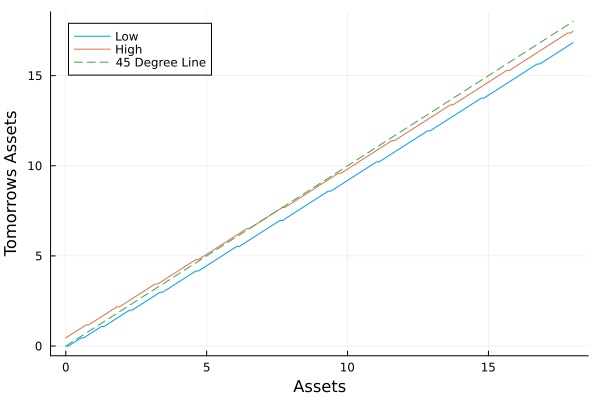

In [56]:
VFI_Ass_R = reshape(VFI_Ass, a_size, z_size)

plot(a_vals, VFI_Ass_R[:,1], xlabel="Assets", ylabel="Tomorrows Assets", label = "Low")
plot!(a_vals, VFI_Ass_R[:,2], label = "High")
plot!(a_vals, a_vals, linestyle=:dash, label = "45 Degree Line")

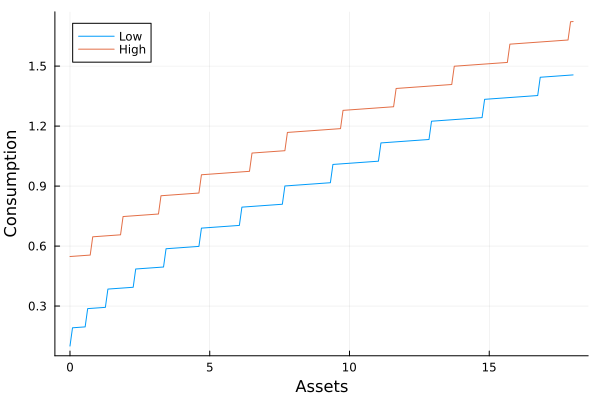

In [57]:
VFI_Cons_R = reshape(VFI_Cons, a_size, z_size)

plot(a_vals, VFI_Cons_R[:, 1], xlabel="Assets", ylabel="Consumption", label="Low")
plot!(a_vals, VFI_Cons_R[:, 2], label="High")

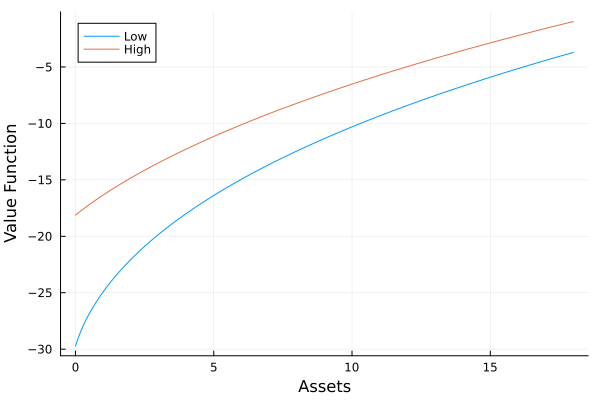

In [58]:

# Reshape the value function to match the grid dimensions
VFI_Value_R = reshape(VFI_Value, a_size, z_size)

plot(a_vals, VFI_Value_R[:,1], xlabel="Assets", ylabel="Value Function", label = "Low")
plot!(a_vals, VFI_Value_R[:,2], label = "High")


### Policy Function Iteration

Now we try do this in Policy Function Iteration. What is Policy Function Iteration? 

- Euler Equation
- Solving the equation
- Comparison
- Refer to: 

#### The Euler Equation

$$u_c(c) = \beta (1+r) \mathbb{E} u_c(c') \text{ if }a' > -B $$

$$u_c(c) \geq \beta (1+r) \mathbb{E}u_c(c'). $$ 

We have created 2 grids. The first for assets today: $a \in \mathcal{A}\equiv \{a_{1}=\underline{a},a_{2},a_{3},...,a_{N}\}$ and the second for the shocks $e\in \mathcal{E}\equiv \{e_{1},...,e_{M}\}$. Furthermore, we have defined $\mathbb{E}$ as $\sum_{k=1}^{M}\pi_{jk},$ with $\pi_{jk}$ being the probability of going from the shock $e_j$ to $e_k$.


Then we have obtained the results by guessing a value function $V_0(): \mathcal{A} \times \mathcal{E} \rightarrow \mathcal{V}$ with $\mathcal{V} \subset \mathbb{R}$, and iterating to obtain the value function that solves to the problem $V()$ 

Now, instead we will guess a consumption function. Let this guess be denoted by $c_{0}() : \mathcal{A} \times \mathcal{E} \rightarrow \mathcal{C}$ with $\mathcal{C} \subset \mathbb{R}$. This function tells us what the consumer will consume for any possible $(a_{i},e_{j}) \in \mathcal{A} \times \mathcal{E} $. A reasonable guess is $$c_{0}(a_{i},e_{j})=r(a_{i}+we_{j})$$

With this guess, we will start the iteration. We will obtain the new value function by solving the Euler Equation, with the future assets determined by the guess. 

$$ u_c(c)\geq \beta (1+r)\sum_{k=1}^{M}\pi_{jk}u_c(c_{0}[\underset{a^{\prime }}{\underbrace{(1+r)a_{i}+we_{j}-c}},e_{k}]))$$

where $c_{0}[(1+r)a_{i}+we_{j}-c,e_{k}]$ tells us if the consumer has state $(a_{i},e_{j})$ and consumes $c$ **today** then **next period** he/she will have asset level $a^{\prime }=(1+r)a_{i}+we_{j}-c,$ and will consume according to the consumption function $c_{0}(a^{\prime },e_{k}),$ where $k$ is next period's shock.

We have to check, however, whether the borrowing constraint binds, i.e. if $c$ could be anything. Suppose the borrowing constraint binds, i.e. today agent decided to save $a^{\prime }=\underline{a}$. Then, the left-hand-side of the Euler equation is given by $$ LHS(\underline{a})=u_c((1+r)a_{i}+we_{j}-\underline{a}), $$

and the right-hand-side is given by $$ RHS(\underline{a})=\beta (1+r)\sum_{k=1}^{M}\pi _{jk}u(c_{0}[\underline{a},e_{k}])$$

If $LHS(\underline{a})\leq RHS(\underline{a}),$ the constraint binds, i.e. even at the lowest asset level, the marginal utility of consumption today is higher than its expected value tomorrow, then we can update the consumption rule as $$ c_{1}(a_{i},e_{j})=(1+r)a_{i}+we_{j}-\underline{a}.$$

If the borrowing constraint is not binding, then we have to solve for $c$ in the following expression.  $$ u_c(c)=\beta (1+r)\sum_{k=1}^{M}\pi_{jk}u_c(c_{0}[(1+r)a_{i}+we_{j}-c,e_{k}])), $$

which is one equation in one unknown $c$. Then we update the consumption policy as $ c_{1}(a_{i},e_{j})= c$. This is a well-behaved problem, the LHS is decreasing in $c$ and the RHS is increasing in $c.$ Hence, we can simply try to find a value for $c$ that solves this expression. 

But there is a problem, remember that we have defined $c_{0}(.)$ on $\mathcal{A}.$ But when we evaluate the RHS of the Euler equation for an arbitrary value of $c$ there is no guarantee that $(1+r)a_{i}+we_{j}-c$ will be on $\mathcal{A}.$ Given $c_{0},$ we can simply interpolate to find the value of $c_{0}$ on points that are not on $\mathcal{A}.$ Given $c_{l}(a_{i},e_{j})$ and $c_{l}(a_{i+1},e_{j}),$ $c_{l}(a,e_{j})$ is given by $$ c_{l}(a,e_{j})=c_{l}(a_{i},e_{j})+\frac{c_{l}(a_{i+1},e_{j})-c_{l}(a_{i},e_{j})}{a_{i+1}-a_{i}}(a-a_{i}).$$

Once we solve for $c,$ we have an updated consumption function $c_{1},$ and then we can start our updating again until convergence: $$\varepsilon _{l}=\max_{i,j}|c_{l+1}(a_{i},e_{j})-c_{l}(a_{i},e_{j})|$$

#### Solving the equation 

You can also write your own **bisection code.** To this end, let $F(c)=u_c(c)-\beta (1+r)\sum_{k=1}^{M}\pi_{jk}u_c(c_{0}[(1+r)a_{i}+we_{j}-c,e_{k}]),$ and we looking for $F(c^{\ast })=0.$

Suppose we find $c_{1}$ and $c_{2}$ such that $F(c_{1})>0\text{ and }F(c_{2})<0.$ Then you take the mid-point of these two initial guesses  $c_{3}=\frac{c_{1}+c_{2}}{2},$ and check $F(c_{3})\lessgtr 0.$ If $F(c_{3})>0,$ then set $c_{1}=c_{3},$ if $F(c_{3})<0,$ then set $c_{2}=c_{3}.$ Calculate again the mid-point,$c_{3}=\frac{c_{1}+c_{2}}{2},$ and check again $F(c_{3})\lessgtr 0.$

#### Comparison
How does Euler equation time iteration compare with value function iteration? On a theoretical level, the two methods are essentially isomorphic and they converge at the same rate.

But the numerical implementation of time iteration is \textbf{faster} and more \textbf{accurate} than value function iteration. The image of policy functions can be calculated faster and with greater accuracy than the image of value functions under the Bellman. The intuition for this result is that:

- the Coleman operator (Policy Function Iteration ) exploits more information because it uses first order and envelope conditions  
- policy functions generally have less curvature than value functions, and hence admit more accurate approximations based on grid point information  

#### References

See Chapter [34](https://julia.quantecon.org/dynamic_programming/optgrowth.html) and [35](https://julia.quantecon.org/dynamic_programming/coleman_policy_iter.html) of QuantEcon

In [59]:
# Generic Bisection Function
function bisection(F, c1, c2, tol=1e-6, max_iter=1000)
    fc1 = F(c1)
    fc2 = F(c2)
    if fc1 * fc2 >= 0
        error("The function values at the initial guesses must have opposite signs.")
    end
    
    iter = 0
    c = (c1 + c2) / 2
    while abs(c2 - c1) > tol && iter < max_iter
        fc = F(c)
        
        if fc == 0
            break
        elseif fc * fc1 < 0
            c2 = c
            fc2 = fc
        else
            c1 = c
            fc1 = fc
        end
        c = (c1 + c2) / 2
        iter += 1
    end
    
    return c
end

bisection (generic function with 3 methods)

In [133]:
# Obtain derivative of the utility function 
u_prime = sigma == 1 ? x -> 1 / x : x -> x^(-sigma)

#58 (generic function with 1 method)

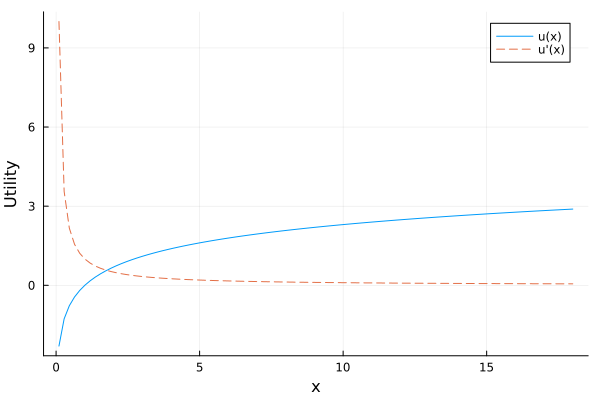

In [134]:
# Create a range of x values
x_vals = range(0.1, 18, length=100)

# Evaluate the utility function and its derivative at each x value
u_vals = u.(x_vals)
u_prime_vals = u_prime.(x_vals)

# Plot the utility function and its derivative
plot(x_vals, u_vals, label="u(x)", xlabel="x", ylabel="Utility")
plot!(x_vals, u_prime_vals, label="u'(x)", linestyle=:dash)

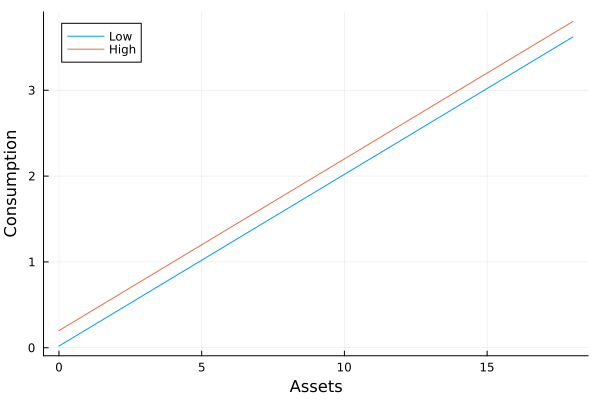

In [135]:
# Guess of policy function: 

PFI_Cons_Guess = zeros(n)

for s_i in 1:n
    PFI_Cons_Guess[s_i] = 0.2*(w * s_vals[s_i, 2] +  s_vals[s_i, 1])
end

PFI_Cons_Guess_R = reshape(PFI_Cons_Guess, a_size, z_size)

plot(a_vals, PFI_Cons_Guess_R[:, 1], xlabel="Assets", ylabel="Consumption", label="Low")
plot!(a_vals, PFI_Cons_Guess_R[:, 2], label="High")



In [136]:
# Generic linear interpolation function 
# This is a bit different 


function linear_interpolation(XGRID, YGRID, input_val)
    n = length(XGRID)
    
    # Ensure input_val is within the bounds
    if input_val <= XGRID[1]
        return YGRID[1]
    elseif input_val >= XGRID[end]
        return YGRID[end]
    end
    
    # Find the interval [s_i, s_i+1] where s_i <= input_val < s_i+1
    for i in 1:(n-1)
        if XGRID[i] <= input_val && input_val < XGRID[i + 1]
            s_i = XGRID[i]
            s_ip1 = XGRID[i + 1]
            c_i = YGRID[i]
            c_ip1 = YGRID[i + 1]
            
            # Linear interpolation formula
            t = (input_val - s_i) / (s_ip1 - s_i)
            return c_i + t * (c_ip1 - c_i)
        end
    end
end

# Could also use the Interpolations Packages

# Test the linear interpolation function
@show PFI_Cons_Guess_R[2,1]
@show PFI_Cons_Guess_R[3,1]
@show a_vals[2]
@show a_vals[3]
@show linear_interpolation(a_vals, PFI_Cons_Guess_R[:,1], 0.13)

0.046000000000000006

Let us compute the LHS and the RHS for only one state, and we consume the amount given by the consumption function

In [137]:
# Given a state s_i, Guess_Policy_Consumption will tell us how much we consume: 
STATE = 1

# From the budget constraint: 
NEXTASSET = w * s_vals[STATE, 2] + (1 + r) * s_vals[STATE, 1] - PFI_Cons_Guess[STATE]


# Now we can compute the RHS of the Euler Equation. 
# Need to use linear interpolation to get the consumption function at the next state.
# Need to obtain the expected value 
RHS = beta * (1+r) * (z_chain.p[s_i_vals[STATE,2],1] * u_prime.(linear_interpolation(a_vals, PFI_Cons_Guess_R[:,1], NEXTASSET)) + 
z_chain.p[s_i_vals[STATE,2],2] * u_prime.(linear_interpolation(a_vals, PFI_Cons_Guess_R[:,2], NEXTASSET)))

# Compute the LHS of the Euler Equation
LHS = u_prime(PFI_Cons_Guess_R[STATE])

@show LHS
@show RHS
@show LHS - RHS



25.311111072052775

Now, let us find the c that equalizes the LHS and the RHS for this state

In [138]:
F(c) = u_prime(c) - beta * (1+r) * (
        z_chain.p[s_i_vals[STATE,2],1] * u_prime.(linear_interpolation(a_vals, PFI_Cons_Guess_R[:,1], w * s_vals[STATE, 2] + (1 + r) * s_vals[STATE, 1] - c)) + 
        z_chain.p[s_i_vals[STATE,2],2] * u_prime.(linear_interpolation(a_vals, PFI_Cons_Guess_R[:,2], w * s_vals[STATE, 2] + (1 + r) * s_vals[STATE, 1] - c)))
@show F(0.01)
@show F(a_max)

bisection(F, 0.01, a_max)

0.03678097680211066

Now, for each state, compute the function F and find the c that gives F = 0

In [139]:
# Calculate the new Consumption Policy Function 
PFI_Cons = similar(PFI_Cons_Guess)

F(c,STATE,NEXT_A_CON,MATRIX) = u_prime(c) - beta * (1+r) *(
    z_chain.p[s_i_vals[STATE,2],1] * u_prime.(linear_interpolation(a_vals, MATRIX[:,1], NEXT_A_CON - c )) + 
    z_chain.p[s_i_vals[STATE,2],2] * u_prime.(linear_interpolation(a_vals, MATRIX[:,2], NEXT_A_CON - c )))
@show F(0.1)

for s_i in 1:n
    
    next_a_con = w * s_vals[s_i, 2] + (1 + r) * s_vals[s_i, 1] 
    next_a = next_a_con - PFI_Cons_Guess[s_i]
    # Check if the budget constraint is binding
    if next_a - a_min <= 0
        PFI_Cons[s_i] = next_a_con - a_min
    # elseif next_a - a_max >= 0
    #     New_Policy_Consumption[s_i] = next_a_con - a_max
    else
        PFI_Cons[s_i] = bisection(c -> F(c,s_i,next_a_con,PFI_Cons_Guess_R), a_min, a_max)
    end
end

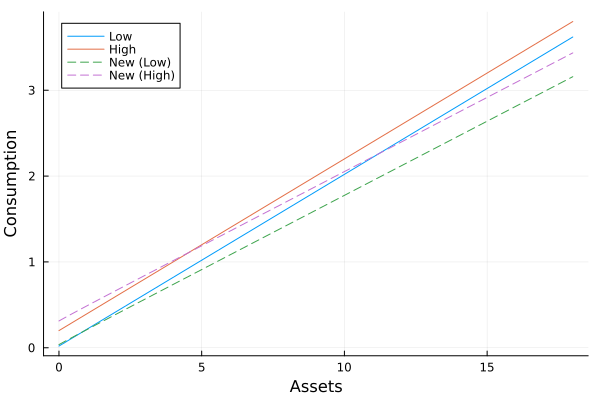

In [143]:
# Plot the new policy function
plot(a_vals, PFI_Cons_Guess_R[:, 1], xlabel="Assets", ylabel="Consumption", label="Low")
plot!(a_vals, PFI_Cons_Guess_R[:, 2], label="High")

PFI_Cons_R = reshape(PFI_Cons, a_size, z_size)
# Plot New_Policy_Consumption_Res
plot!(a_vals, PFI_Cons_R[:, 1], label="New (Low)", linestyle=:dash )
plot!(a_vals, PFI_Cons_R[:, 2], label="New (High)",  linestyle=:dash)

In [144]:
# Iterate over the updating process until convergence
max_iter = 1000
tol = 1e-6
iter = 0
while iter < max_iter
    for s_i in 1:n
    
        next_a_con = w * s_vals[s_i, 2] + (1 + r) * s_vals[s_i, 1] 
        next_a = next_a_con - PFI_Cons_Guess[s_i]
        # Check if the budget constraint is binding
        if next_a - a_min <= 0
            PFI_Cons[s_i] = next_a_con - a_min
        elseif next_a - a_max >= 0
            PFI_Cons[s_i] = next_a_con - a_max
        else
            PFI_Cons[s_i] = bisection(c -> F(c,s_i,next_a_con,PFI_Cons_Guess_R), a_min, a_max)
        end
    end    
    
    if maximum(abs.(PFI_Cons_Guess - PFI_Cons)) < tol
        println("Converged after $iter iterations.")
        break
    end
    PFI_Cons_Guess = copy(PFI_Cons)
    PFI_Cons_Guess_R = reshape(PFI_Cons_Guess, a_size, z_size)

    iter += 1
end


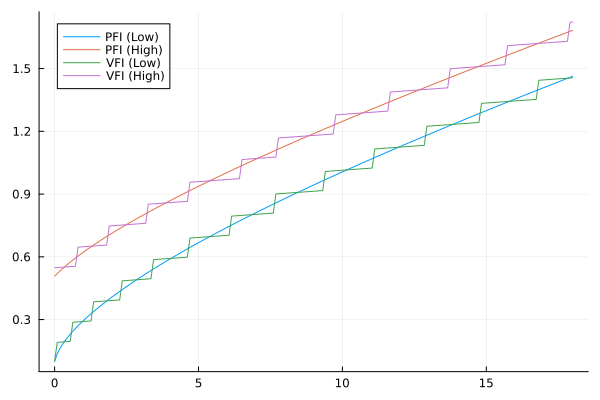

In [145]:
PFI_Cons = reshape(PFI_Cons, a_size, z_size)
# Plot New_Policy_Consumption_Res
plot(a_vals, PFI_Cons_R[:, 1], label="PFI (Low)")
plot!(a_vals, PFI_Cons_R[:, 2], label="PFI (High)")

plot!(a_vals, VFI_Cons_R[:, 1], label="VFI (Low)")
plot!(a_vals, VFI_Cons_R[:, 2], label="VFI (High)")



In [146]:
PFI_Ass_R = similar(PFI_Cons_R)
for z in 1:z_size
    for a in 1:a_size
        PFI_Ass_R[a, z] = w*z_vals[z] + (1+r)*a_vals[a] - PFI_Cons_R[a, z]
    end
end



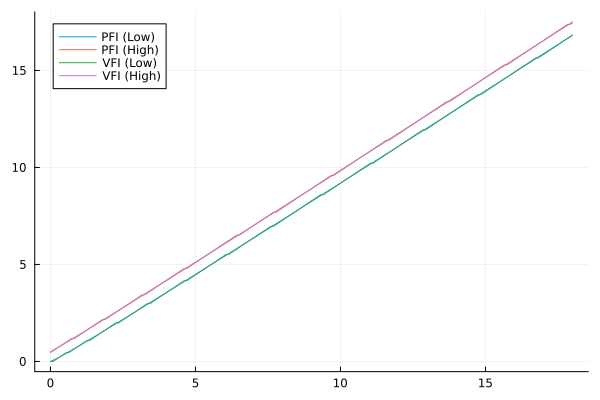

In [147]:

plot(a_vals, PFI_Ass_R[:, 1], label="PFI (Low)")
plot!(a_vals, PFI_Ass_R[:, 2], label="PFI (High)")

plot!(a_vals, VFI_Ass_R[:, 1], label="VFI (Low)")
plot!(a_vals, VFI_Ass_R[:, 2], label="VFI (High)")

### Endogenous Grid Metheod

Trick to speed up the problem. Look at the Euler Equation: $$u_c(e_j w + (1+r)a - a') - \beta (1+r) \sum_{k=1}^{M}\pi_{jk}u_{c}(we_k + (1+r)a' - c_0(e_k,a')), $$ where $c_0()$ is a guessed policy function. What we were doing in PFI is solving for $a'$ given state $(e_j,a)$. The Equation is **non-linear** in $a'$. 

What if we do the opposite? Take $e_j$ and $a'$ as given, and solve for $a$. The equation is linear in $a$. Much Faster!! 

The main idea is to set up a grid for $a'$, and search for the $a$ that solves the Euler Equation for each pair $(e_j,a')$

#### Details

First we construct the **EXOGENOUS** grid of assets tomorrow $a,$ i.e. $a \in \mathcal{A}\equiv \{a_{1}=\underline{a},a_{2},a_{3},...,a_{N}\}$ (like before) and of shocks $e\in \mathcal{E}\equiv \{e_{1},...,e_{M}\}$

Given $e_j$ and $a_{i}'$ in the grid space, and a guess of the policy function, then we can obtain the RHS of the Euler Equation is: $$RHS(a'_{i},e_{j})= \beta (1+r) \sum_{k=1}^{M}\pi_{jk}u_c(c_{0}(a_{i}^{\prime },e_{k})).$$ This is a number. 

Then from the Euler Equation, we can obtain (closed form!) the consumption that we would have for a given $e_j$ and $a'$
$$u_c(c_{0}(a_{i}^{\prime },e_{j})) = RHS(a'_{i},e_{j}) \Rightarrow \tilde{c}_{0}(a_{i}^{\prime },e_{j}) = u_c^{-1}(RHS(a'_{i},e_{j})) $$

So, we have assets tomorrow, consumption and income today. Using the budget constraint we can obtain a function to obtain the optimal assets today $$a(a_{i}^{\prime },e_{j})=\frac{\tilde{c}_{0}(a_{i}^{\prime},e_{j})+a_{i}^{\prime }-we_{j}}{1+r}.$$ This will give us the **ENDOGENOUS** grid for todays's assets. This is the opposite of what we want normally. What we want is the state $(e_j,a)$ assets TODAY. But we can simply invert the function $a(a_{i}^{\prime },e_{j})$ to obtain  $a'(a,e_{j})$. Notice that the function $a()$ is just a list of number, inverting means just switching!

So: the function $a():\mathcal{A} \times \mathcal{E} \rightarrow \mathcal{A}^N, $ where $\mathcal{A}^N \in \mathbb{R}$ is a new grid. The inverse function we are looking for, $a'():\mathcal{A}^N \times \mathcal{E} \rightarrow \mathcal{A}, $ where $\mathcal{A}^N \in \mathbb{R}$ is a new grid. 

From this:

| $\mathcal{A} \times \mathcal{E}$ | $a(a_{i}',e_{j})$  | $\mathcal{A}^N$ |
| --- | --- | --- |
| $(a_{1}',e_{1})$ | $\rightarrow$ | $x$ |
| $(a_{2}',e_{1})$ | $\rightarrow$ | $y$ |
| ... |  |  |
| $(a_{N}',e_{M})$ | $\rightarrow$ | $z$ |

We get:

| $\mathcal{A}^N \times \mathcal{E}$ | $a'(a_{i},e_{j})$  | $\mathcal{A}$ |
| --- | --- | --- |
| $(x,e_{1})$ | $\rightarrow$ | $a_{1}'$ |
| $(y,e_{1})$ | $\rightarrow$ | $a_{2}'$ |
| ... |  |  |
| $(z,e_{M})$ | $\rightarrow$ | $a_{N}'$ |


But now, we want to have the function $a'()$ to be defined on our **exogenous** grid, and not the **endogenous** $a'():\mathcal{A} \times \mathcal{E} \rightarrow \mathbb{R}$. This can be done with interpolation. Finally, given a value of current assets $a_i \in \mathbb{A}$ and a shock $e_j$, using our function $a'(a_i,e_j)$, that tells us the assets tomorrow, and the budget constraint, we can obtain a **new** guess of our consumption policy function $$c_1(a_i,e_j) = (1+r) a_i + we_k - a'(a_i,e_j)$$  

To deal with the lower bound: $a' \geq B$. Notice that a(a_i',e_j), tells us what asset must I jabe today if I choose optimally $a_i'$ for tomrorow. We can find $a(a_{min},e_j) =  a^{*}(e_j), and we set the new guess $c_1(a_i,e_k) = (1+r) a_i + we_k - a^{*}(e_j)$

#### Sketch of a code


1. **Initialize Grids:**
   - Create grids for assets and income.

2. **Define Utility Functions:**
   - Define the utility function `u(c)` and its derivative `u_prime(c)`.
   - Define the inverse of the marginal utility function `u_prime_inv(uc)`.

3. **Initial Guess for Policy Functions:**
   - Initialize guesses for the policy functions for consumption.

4. **Policy Function Iteration:**
   
   - For each grid point of assets and income:
      - Compute the expected marginal utility of future consumption.
      - Compute current consumption policy using the inverse marginal utility function.
      - Obtain the endogenous grid that tells us the asset today needed to obtain assets tomorrow.
      - Inverse and interpolate the endogenous grid.
      - Update the consumption policy.

5. **Convergence Check:**
   - If the policy functions converge within a specified tolerance, stop the iteration.




In [72]:
# 1. Initialize grid: We alrady have it! 
a_grid = collect(a_vals)
z_grid = copy(z_vals)

# 2. Utility functions:
u_prime = sigma == 1 ? x -> 1 / x : x -> x^(-sigma)
u_prime_inv = sigma == 1 ? x ->  1 / x : x -> x^(-1/sigma)


# 3. Guesses of Policy functions 
EG_Cons_Guess = zeros(length(a_grid),length(z_grid))

for z in 1:length(z_grid)
    for a in 1:length(a_grid)
        EG_Cons_Guess[a,z] = 0.2*(w * z_grid[z]) + 0.1 * a_grid[a]
    end
end

EG_Ass_Guess = similar(EG_Cons_Guess);


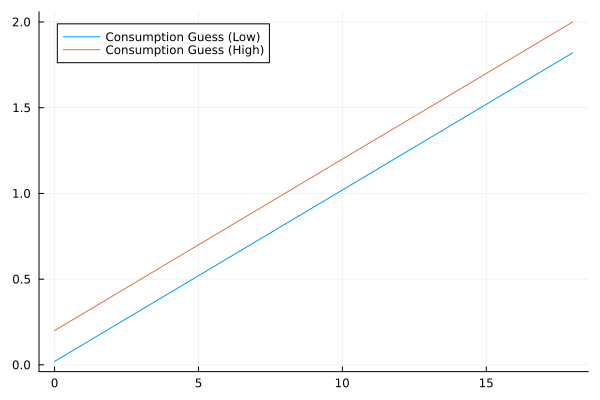

In [73]:
# Plot New_Policy_Consumption_Res
plot(a_vals, EG_Cons_Guess[:, 1], label="Consumption Guess (Low)")
plot!(a_vals, EG_Cons_Guess[:, 2], label="Consumption Guess (High)")



In [74]:
# Calculate RHS for a given state (assets tomorrow, shock today)
STATE_aprime = 1 
STATE_shock = 1
RHS = beta * (1+r) *(   z_chain.p[STATE_shock,1] * u_prime(EG_Cons_Guess[STATE_aprime,1])+
                        z_chain.p[STATE_shock,2] * u_prime(EG_Cons_Guess[STATE_aprime,2]))
@show RHS

# Calcuate Consumption 
c = u_prime_inv(RHS)
@show c

RHS = 44.116799978159754
c = 0.022667101886244132


0.022667101886244132

Now we do this for every aprime and every shock

In [75]:
EG_Ass = similar(EG_Ass_Guess)


for z in 1:length(z_grid)
    for a_prime in 1:length(a_grid)
        RHS = beta * (1+r) *(   z_chain.p[z,1] * u_prime(EG_Cons_Guess[a_prime,1])+
                                z_chain.p[z,2] * u_prime(EG_Cons_Guess[a_prime,2]))
        C_solution = u_prime_inv(RHS)
        EG_Ass[a_prime,z] = (C_solution + a_grid[a_prime] - w * z_grid[z])/(1+r)
    end
end

# this is the endogenous grid
@show EG_Ass[1:5,1]
@show a_grid[1:5]

# To obtain the policy function EG_AssPrime we need to interpolate
# Currently: X is a_grid, Y is EG_Ass
# We revert this: X is EG_Ass, Y is a_grid
# function linear_interpolation(XGRID, YGRID, input_val)

EG_AssPrime = similar(EG_Ass)
for z in 1:length(z_grid)
    for a_prime in 1:length(a_grid)
        EG_AssPrime[a_prime,z] = linear_interpolation(EG_Ass[:,z],a_grid,a_grid[a_prime])
    end
end
@show EG_AssPrime[1:5,:]

# Update the consumption policy function
EG_Cons = similar(EG_Cons_Guess)
for z in 1:length(z_grid)
    for a in 1:length(a_grid)
        EG_Cons[a,z] = (1+r)*a_grid[a] + w*z_grid[z] - EG_AssPrime[a,z]
    end
end




EG_Ass[1:5, 1] = [-0.07656722575619393, 0.023000540443388888, 0.12249827272095534, 0.2219350580864258, 0.3213184766523182]
a_grid[1:5] = [1.0e-10, 0.09045226140603015, 0.1809045227120603, 0.27135678401809044, 0.3618090453241206]
EG_AssPrime[1:5, :] = [0.06955743806380658 0.760294149523625; 0.15177185684197433 0.8415094903734803; 0.23403352689983314 0.9229210500536427; 0.31633719355393336 1.004495596058642; 0.3986783357312002 1.0862068197761605]


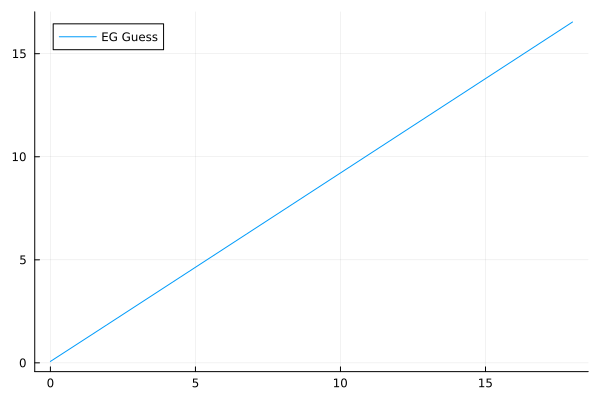

In [76]:
plot(a_vals, EG_AssPrime[:, 1], label="EG Guess")


In [149]:
# now we can iterate 

# Iterate over the updating process until convergence
max_iter = 1000
tol = 1e-6
iter = 0
while iter < max_iter

    # Find c and function for asset today, given asset tomorrow and shocks
    for z in 1:length(z_grid)
        for a_prime in 1:length(a_grid)    
            RHS = beta * (1+r) *(   z_chain.p[z,1] * u_prime(EG_Cons_Guess[a_prime,1])+
                                    z_chain.p[z,2] * u_prime(EG_Cons_Guess[a_prime,2]))
            C_solution = u_prime_inv(RHS)
            EG_Ass[a_prime,z] = (C_solution + a_grid[a_prime] - w * z_grid[z])/(1+r)
        end
    end    

    # Interpolate from endogenous grid to exogenous grid 
    for z in 1:length(z_grid)
        for a in 1:length(a_grid)
            EG_AssPrime[a,z] = linear_interpolation(EG_Ass[:,z],a_grid,a_grid[a])
        end
    end

    # Use asset prime function and budget constraint to update the consumption policy function
    for z in 1:length(z_grid)
        for a in 1:length(a_grid)
            EG_Cons[a,z] = (1+r)*a_grid[a] + w*z_grid[z] - EG_AssPrime[a,z]
        end
    end

    
    if maximum(abs.(EG_Cons_Guess - EG_Cons)) < tol
        println("Converged after $iter iterations.")
        break
    end
    EG_Cons_Guess = copy(EG_Cons)
    iter += 1
end

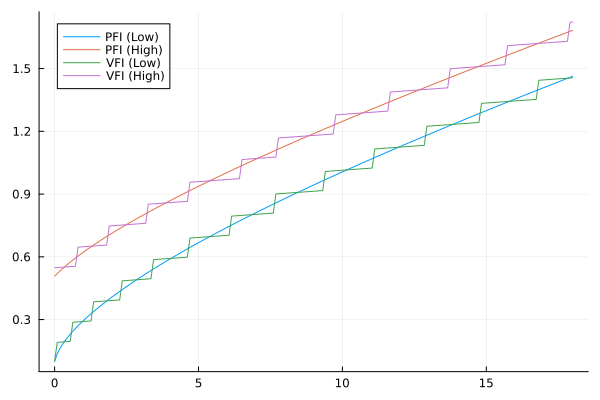

In [150]:
# Plot New_Policy_Consumption_Res
plot(a_vals, PFI_Cons_R[:, 1], label="PFI (Low)")
plot!(a_vals, PFI_Cons_R[:, 2], label="PFI (High)")

plot!(a_vals, VFI_Cons_R[:, 1], label="VFI (Low)")
plot!(a_vals, VFI_Cons_R[:, 2], label="VFI (High)")





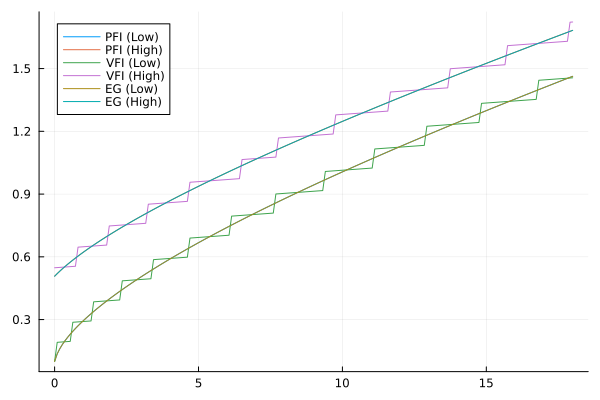

In [151]:
plot!(a_vals, EG_Cons[:, 1], label="EG (Low)")
plot!(a_vals, EG_Cons[:, 2], label="EG (High)")

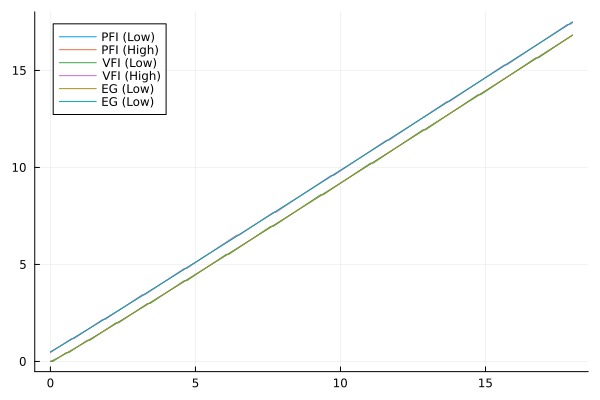

In [152]:

plot(a_vals, PFI_Ass_R[:, 1], label="PFI (Low)")
plot!(a_vals, PFI_Ass_R[:, 2], label="PFI (High)")

plot!(a_vals, VFI_Ass_R[:, 1], label="VFI (Low)")
plot!(a_vals, VFI_Ass_R[:, 2], label="VFI (High)")

plot!(a_vals, EG_AssPrime[:, 1], label="EG (Low)")
plot!(a_vals, EG_AssPrime[:, 2], label="EG (Low)")



## Stationary Distribution

We have obtainen, for a given interest rate and wage, the policy functions of the households. No we want to compute the staionary distribution of the households, using the markov shocks, and the policy functions. There are two main ways of doing this: Simulation and Young's method. 

### Simulation

In this case we simulate a large set of households,$I$, and periods $T$. Then give to each household $i \in I$ an initial value of the shock $e$ and assets 0. Given these, solve the consumption today and assets next period for each $i$, then get a new draw of the shocks using the Markov Chain. Compute mean asset holding (or other moments) as $$A_{t}=\frac{1}{I}\sum_{i=1}^{T}a_{it}, $$ until $A$ converges.

Notice that, depending on the asset policy function that we computed, we need to change our method for the transitions. If we have a policy function **on the grid**, i.e., that goes from point $a_i \in \mathcal{A}$ to $a_l' \in \mathcal{A}$, then it is quite easy. For a person $i$ who has $(a_i,e_j)$, we use our policy function, and know that next period the person will start from $(a_l',e_k)$. 

Meanwhile, if our policy is not on the grid, i.e., that goes from point $a_i \in \mathcal{A}$ to $a' \in \mathbb{R}$, then we need an additional step. For a person $i$ who has $(a_i,e_j)$ we know that his next asset will be $a'$. We can find an index $l$ such that $a_l' \in \mathcal{A} : a_l' \leq a' \leq  a_{l+1}'$. Finally, we can randomly assign that person to start the next period in either $a_l$ or in $a_{l+1}$. The probability of being assigned depend on the distance. 

**Example** Assume you have $a_l = 0$ or in $a_{l+1} = 1$ and $a' = 0.7$ obtained from the policy function. Then $\mathbb{P}(a' = a_{l+1}) = \frac{a' - a_l'}{a_{l+1}' - a_l'} = \frac{0.7-0}{1-0}=0.7$



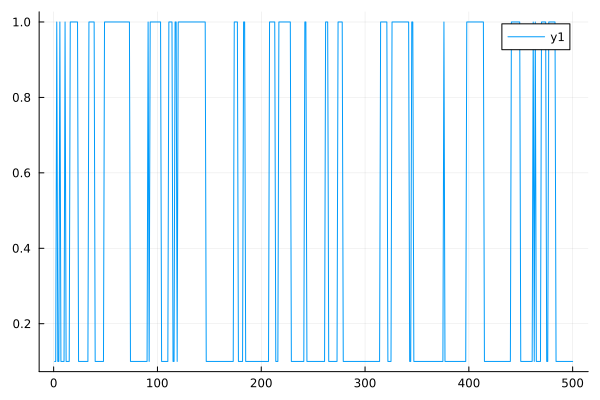

In [88]:
# Set I = 1000, T = 1000 
I = 2000 
T = 500 
Shocks_idx = zeros(Int64,I,T)
Shocks_val = zeros(Float64,I,T)

# Create series of shocks 
Stat_dist = stationary_distributions(z_chain)
Rand_draws = rand(I,T)

for i in 1:I 

    # Initialize shocks from stationary distribution
    #this works only as we have 2 states! Use cumulative normally!
    if Rand_draws[i,1] <  Stat_dist[1][1] 
        Shocks_idx[i,1] = 1 
    else 
        Shocks_idx[i,1] = 2 
    end

    # Use transition matrix for all the rest of the periods
    Shocks_idx[i,2:T] = simulate_indices(z_chain, T-1, init=Shocks_idx[1,1])
    
end
Shocks_val = z_chain.state_values[Shocks_idx];
plot(1:T, Shocks_val[5,:])

In [89]:
# use the Asset policy function to move from asset today to asset tomorrow! 
# Notice, I'll use the Policy function obtained with VFI on grid 

VFI_Ass_Idx_R = reshape(VFI_Ass_Idx, a_size, z_size)
Assets_idx = ones(Int64,I,T) # Initialize at lowest asset

for i in 1:I 
    for t in 2:T
        Assets_idx[i,t] = VFI_Ass_Idx_R[Assets_idx[i,t-1],Shocks_idx[i,t-1]]
    end
end

Assets_val = a_vals[Assets_idx]


2000×500 Matrix{Float64}:
 1.0e-10  1.0e-10   1.0e-10   1.0e-10   …  1.26633   1.62814    1.98995
 1.0e-10  1.0e-10   1.0e-10   1.0e-10      0.542714  0.452261   0.361809
 1.0e-10  1.0e-10   1.0e-10   1.0e-10      5.06533   5.15578    5.24623
 1.0e-10  1.0e-10   1.0e-10   1.0e-10      1.62814   1.98995    2.26131
 1.0e-10  1.0e-10   1.0e-10   0.452261     0.180905  0.0904523  1.0e-10
 1.0e-10  1.0e-10   1.0e-10   1.0e-10   …  1.98995   1.71859    1.44724
 1.0e-10  1.0e-10   1.0e-10   1.0e-10      3.25628   3.43719    3.61809
 1.0e-10  0.452261  0.361809  0.81407      3.79899   3.9799     4.1608
 1.0e-10  1.0e-10   1.0e-10   1.0e-10      5.78894   5.8794     5.96985
 1.0e-10  0.452261  0.361809  0.271357     6.0603    6.15075    5.51759
 ⋮                                      ⋱                       
 1.0e-10  1.0e-10   1.0e-10   0.452261     0.361809  0.271357   0.180905
 1.0e-10  1.0e-10   1.0e-10   1.0e-10      4.07035   4.25126    3.79899
 1.0e-10  0.452261  0.361809  0.271357     5

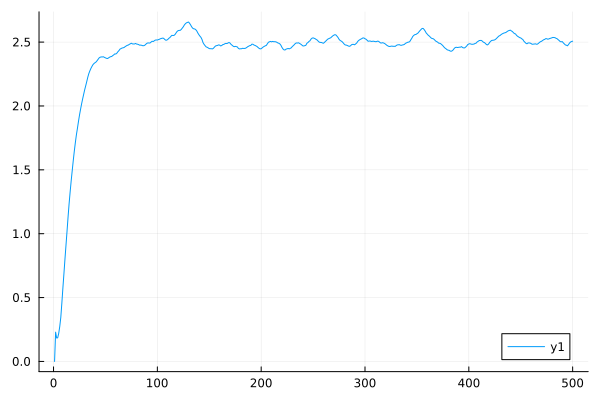

In [92]:
# Compute mean assets 
mean_assets = mean(Assets_val, dims=1)

plot(1:T,mean_assets')

### Young's Method

The second way to obtain the stationary distribution is to normalize the population to 1 and use fractions over the state space $\mathcal{S} := \mathcal{A} \times \mathcal{E}$. The sum across each combination of assets and shock has to be one. Each cell tells us the fraction of people that have a specific asset and shock. We start with a uniform distribution, then we iterate using the transition probabilities. More precisely, let $\phi_0$ be an initial distribution over the state space $\mathcal{S}$. This means that $\phi_0(s)$ tells us the fraction of people in $s$. Furthermore, $\sum_{\mathcal{S}} \phi_0(s) = 1$.  Let $\mathcal{Q}$ be the transition probability between $s \in \mathcal{S}$ to $s' \in \mathcal{S}$. We obtained $\mathcal{Q}$ by combining the policy function of assets and the transition probability from the shocks!. Then, we compute the stationary distribution related to $\mathcal{Q}$. You can do this the way you want! 

In [108]:
# Create transition probability 
# We can actually start with the matrix Q we computed, and just keep the "Optimal action" 

Q_Opt_Tras = zeros(n,n)

for i in 1:n 
    OptDec = VFI_Ass_Idx[i]
    Q_Opt_Tras[i,:] = Q[i,OptDec,:]
end

@show sum(Q_Opt_Tras,dims = 2)


sum(Q_Opt_Tras, dims = 2) = [1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1

400×1 Matrix{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

In [123]:
# Find stationary distribution of Q_Opt
# Use the quant econ routine. Need to create a markov process object: 
Q_Opt_MC = MarkovChain(Q_Opt_Tras, s_vals[:,1])


Stat_Dist_Opt = stationary_distributions(Q_Opt_MC)

@show Stat_Dist_Opt[1]

println("Result1")
Stat_Dist_Opt[1]' * s_vals[:,1]



2.503373340701177

2.503373340701177

## Equilibrium 

In order to find an equilibrium, we start from some initial guess for interest rate.

Due to CRS, once you know $r,$ you know $w$ since $$ w=F_{L}(F_{K}^{-1}(r+\delta ))$$

Given $(r,w),$ we can solve the problem of the agents and find the
aggregate supply of capital, call it $A(r).$

The demand for capital is given by $$K(r)=LF_{K}^{-1}(r+\delta ),$$ where $L$ is the aggregate labor input (which is constant).

Then the equilibrium is given by $$K(r^{\ast })-A(r^{\ast })=0.$$

You can do a bisection with $r_{1}=-\delta $ and $r_{2}=\frac{1}{\beta}-1.$


First, we will show demand and supply of Kapital for a range of interest rates. 
We will do this using the QuantEcon routines to obtain the policy functions. However, we could have written our own routine using the codes we did!

In [125]:
function Household(; r = 0.01,
    w = 1.0,
    sigma = 1.0,
    beta = 0.96,
    z_chain = MarkovChain([0.9 0.1; 0.1 0.9], [0.1; 1.0]),
    a_min = 1e-10,
    a_max = 18.0,
    a_size = 200,
    a_vals = range(a_min, a_max, length = a_size),
    # -Inf is the utility of dying (0 consumption)
    u = sigma == 1 ? x -> log(x) :
        x -> (x^(1 - sigma) - 1) / (1 - sigma))

    # Create grids
    z_size = length(z_chain.state_values)
    n = a_size * z_size
    s_vals = gridmake(a_vals, z_chain.state_values)
    s_i_vals = gridmake(1:a_size, 1:z_size)

    # Fill in the Q and R
    Q = zeros(n, a_size, n)
    for next_s_i in 1:size(Q, 3)
        for a_i in 1:size(Q, 2)
            for s_i in 1:size(Q, 1)
                z_i = s_i_vals[s_i, 2]
                next_z_i = s_i_vals[next_s_i, 2]
                next_a_i = s_i_vals[next_s_i, 1]
                if next_a_i == a_i
                    Q[s_i, a_i, next_s_i] = z_chain.p[z_i, next_z_i]
                end
            end
        end
    end

    R = fill(-Inf, n, a_size)
    for new_a_i in 1:size(R, 2)
        a_new = a_vals[new_a_i]
        for s_i in 1:size(R, 1)
            a = s_vals[s_i, 1]
            z = s_vals[s_i, 2]
            c = w * z + (1 + r) * a - a_new
            if c > 0
                R[s_i, new_a_i] = u(c)
            end
        end
    end
    
    return (; r, w, sigma, beta, z_chain, a_min, a_max, a_size, a_vals, z_size,
    n, s_vals, s_i_vals, u, R, Q)
end

Household (generic function with 1 method)

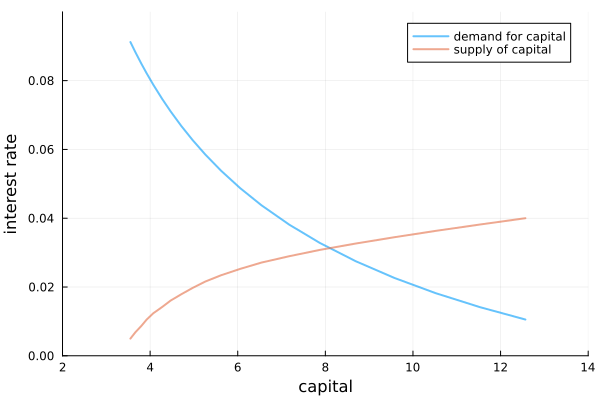

In [126]:
# Calculate supply of capital for a given r
function prices_to_capital_stock(r; beta, A, N, alpha, delta, a_max)
    # Create an instance of Household given the parameters

    # Calculate the equilibrium wages
    w = A * (1 - alpha) * (A * alpha / (r + delta))^(alpha / (1 - alpha))
    am = Household(; beta, a_max, w, r)

    aiyagari_ddp = DiscreteDP(am.R, am.Q, am.beta)

    # Compute the optimal policy
    results = solve(aiyagari_ddp, PFI)

    # Compute the stationary distribution
    stationary_probs = stationary_distributions(results.mc)[:, 1][1]

    # Return K
    K = dot(am.s_vals[:, 1], stationary_probs)

    # Return capital
    return K
end

# Inverse Demand for capital
function r_inverse_demand(K; A, N, alpha, delta)
    return A * alpha * (N / K)^(1 - alpha) - delta
end

# Create a grid of r values at which to compute demand and supply of capital
r_vals = range(0.005, 0.04, length = 20)

# Create a grid of r values at which to compute demand and supply of capital
r_vals = range(0.005, 0.04, length = 20)

# Firms' parameters
A = 1
N = 1
alpha = 0.33
beta = 0.96
delta = 0.05
a_max = 18.0

prices_to_capital_stock(r_vals[1]; A, N, alpha, beta, delta, a_max)

# Compute supply of capital
k_vals = prices_to_capital_stock.(r_vals; A, N, alpha, beta, delta, a_max)

r_inverse_demand_vals = r_inverse_demand.(k_vals; A, N, alpha, delta)

# Plot against demand for capital by firms
labels = ["demand for capital" "supply of capital"]
plot(k_vals, [r_inverse_demand_vals r_vals], label = labels, lw = 2,
     alpha = 0.6)
plot!(xlabel = "capital", ylabel = "interest rate", xlim = (2, 14),
      ylim = (0.0, 0.1))

Now, we can solve the model using our bisection function. We create a function $F(r) = K(r^{\ast })-A(r^{\ast })$

In [ ]:
#  Demand for capital
function K_demand(r; A, N, alpha, delta)
    return N/((r + delta)/(A * alpha))^(1/(1 - alpha))
end

F(r) = K_demand(r; A, N, alpha, delta) - prices_to_capital_stock(r; A, N, alpha, beta, delta, a_max)
F(0.04)
F(0.02)

In [131]:
Equilibrium_Rate = bisection(F,0.02,0.04)
@show Equilibrium_Rate

0.03129241943359375

In [132]:
Equilibrium_Capital = prices_to_capital_stock(Equilibrium_Rate; A, N, alpha, beta, delta, a_max)

8.099381365237894